# Trabajo práctico integrador: Computer Vision II - Modelo sin pesos pre-entrenados

Especialización en IA - FIUBA
4to bimestre 2022

Integrantes:
* Anahi Bazet
* Lionel Gutierrez 


## Objetivo

Esta notebook es una extensión de "TP final CV2- 5Cohorte CEIA- Habitaciones.ipynb". Aquí se busca entrenar el modelo AlexNet si aplicar transfer learning, es decir, entrenando todos sus pesos. Precisamente, se ejecutan dos variantes: 

* La primera utiliza todos los tipos de data augmentation elegidos en la notebook principal.
* La segunda, no aplica data augmentation.

Por último, se extraen conclusiones comparando con el modelo de Alexnet en donde se aplicó transfer learning, tanto cuando posee data augmentation, como cuando no se utiliza.

## Importación de librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import copy
import torchvision
import torchsummary

!pip install torchmetrics
import torchmetrics
import matplotlib.image as mpimg
import pandas as pd

from torch.utils.data import DataLoader, random_split

#Modelos 
from torchvision.models.alexnet import AlexNet_Weights
import torchvision.models as modelos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.2 MB/s 


## Importación del dataset

El dataset es el siguiente: https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset

In [ ]:
# https://drive.google.com/file/d/1BXo2ErTJbZ3YWTVhE2C8mV4oeGoEwBzh/view?usp=sharing
!gdown --id 1BXo2ErTJbZ3YWTVhE2C8mV4oeGoEwBzh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1BXo2ErTJbZ3YWTVhE2C8mV4oeGoEwBzh
To: /content/Habitaciones.zip
100% 122M/122M [00:00<00:00, 147MB/s]


In [ ]:
# Se descomprime el dataset.
!unzip   /content/Habitaciones.zip > /dev/null

In [ ]:
# Se guarda la ruta base en una variable.
path_base = '/content/House_Room_Dataset'

## Conección a google drive para guardar los modelos ejecutados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploración del dataset

In [ ]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(224, 224))
                  ])

set = torchvision.datasets.ImageFolder(root=path_base, transform=data_transforms)

In [ ]:
# Cantidad de clases del set de datos y cantidad de datos del mismo.
cantidad_clases = len(set.classes) 
longitud_set = len(set)
print("Cantidad de imagenes del dataset: ",longitud_set)
print("Cantidad de clases del dataset: ",cantidad_clases)

Cantidad de imagenes del dataset:  5250
Cantidad de clases del dataset:  5


In [ ]:
print("Las clases del dataset son: ",set.classes)

Las clases del dataset son:  ['Bathroom', 'Bedroom', 'Dinning', 'Kitchen', 'Livingroom']


In [ ]:
# Conformación del set de datos.
(img, class_img) = set[0]
print (type(img))
print (class_img)

<class 'PIL.Image.Image'>
0


In [ ]:
# Por cada imagen: la ruta y la clase a la que pertenece.
set.imgs[0]

('/content/House_Room_Dataset/Bathroom/bath_1.jpg', 0)

(224, 224, 3)


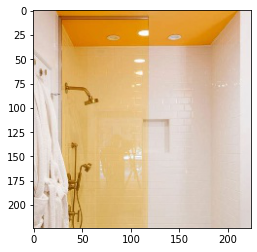

In [ ]:
# Se muestra una imagen.
# image = mpimg.imread(path_base+"/Bathroom/bath_2.jpg")
image= mpimg.imread(set.imgs[0][0])

print(image.shape)
plt.imshow(image)
plt.show()

## Split en entrenamiento, validación y pruebas

In [ ]:
valid_size = 0.1
test_size = 0.1
n_val = int(np.floor(valid_size * longitud_set))
n_test = int(np.floor(test_size * longitud_set))
n_train = longitud_set - n_val - n_test

train_ds_original, val_ds_original, test_ds_original = random_split(set, [n_train, n_val, n_test])


## Transformaciones: data augmentation

In [ ]:
# Solo la conversión a tensor.
transform_to_tensor = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()
                      ])

In [ ]:
# Data augmentation sobre rotación, color (brillo, contraste y matiz) y desenfoque gaussiano.
# Se aplica de forma aleatoria con una probabilidad.
# Conversión a tensor.
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.RandomRotation(degrees=180)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.ColorJitter(brightness=0.05,contrast=0.05, hue=0.05)]),p=0.5),
                        torchvision.transforms.RandomApply(torch.nn.ModuleList([torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))]),p=0.5),
                        torchvision.transforms.ToTensor()
                      ])


In [ ]:
# Se realizan copias de los dataset originales.
test_ds =  copy.deepcopy(test_ds_original)
train_ds = copy.deepcopy(train_ds_original)
val_ds = copy.deepcopy(val_ds_original)

In [ ]:
# Al dataset de test solo se aplica la transformación de conversión a tensor.
test_ds.dataset.transform = transform_to_tensor
# Al resto, se le aplica data augmentation + conversión a tensor.
train_ds.dataset.transform = aug_data_transforms
val_ds.dataset.transform = aug_data_transforms

In [ ]:
# Tamaños de los set de datos.
print ("Entrenamiento:",len(train_ds))
print ("Validación:",len(val_ds))
print ("Prueba:",len(test_ds))

Entrenamiento: 4200
Validación: 525
Prueba: 525


## Funciones de train y test genéricas para todos los modelos

In [ ]:
# Recibe los siguientes parámetros:
# model: el modelo a entrenar.
# criterion: función de pérdida a utilizar.
# optimizer: optimizador a utilizar.
# train_loader: set de datos de entrenamiento.
# valid_loader: set de datos de validación.
# epochs: cantidad de épocas a entrenar.
# model_name: ruta y nombre del modelo para poder almacenarlo.

# Devuelve lo siguiente:
# model: el modelo que se envió por parámetro.
# history: métricas y función de pérdida de entrenamiento y validación para cada época.
# num_epoch_best_val_acc: el número de época que obtuvo la mejor métrica de validación.
# best_valid_acc: la mejor métrica de validación. 

def train(model, criterion, optimizer, train_loader, valid_loader, epochs,model_name):

    accuracy_metric = torchmetrics.Accuracy(average='macro', num_classes=cantidad_clases)# average='weighted'

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    # Aca vamos guardando la mejor accuracy para luego guardar el mejor modelo
    best_valid_acc = 0.0 
    num_epoch = 0
    num_epoch_best_val_acc = 0
    
    for epoch in range(epochs):
        num_epoch += 1
        # Ponemos el modelo en modo entrenamiento.
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Ponemos el modelo en modo validación.
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            #print("valid target:",valid_target)
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            #print("output:",output.to("cpu"))
            
            epoch_valid_loss += criterion(output, valid_target).item()
            acuracy_step = accuracy_metric(output, valid_target).item()
            epoch_valid_accuracy += acuracy_step
            #print("Accuracy del paso: ",acuracy_step)
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)
        
        # Si la métrica de validación es mejor que la almacenada anteriormente.
        if (epoch_valid_accuracy > best_valid_acc):
            # Nos quedamos con la nueva métrica de validación.
            best_valid_acc = epoch_valid_accuracy
            # Gurdamos el modelo como candidato.
            torch.save(model.state_dict(), model_name)
            # Nos quedamos con el número de época actual.
            num_epoch_best_val_acc = num_epoch

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history, num_epoch_best_val_acc, best_valid_acc

In [ ]:
# Recibe los siguientes parámetros:
# model: el modelo a probar.
# model_loss: función de pérdida.
# model_params: ruta y nombre del modelo para poder cargar sus parámetros.
# test_loader: set de datos de pruebas.

# Devuelve lo siguiente:
# test_loss: error de la prueba.
# test_accuracy: métrica de la prueba.

def test(model, model_loss, model_params, test_loader):

  accuracy_metric = torchmetrics.Accuracy(average='macro', num_classes=cantidad_clases)# average='weighted'

  if torch.cuda.is_available():
     model.to("cuda")
     accuracy_metric.to("cuda")

  model.load_state_dict(torch.load(model_params))
  model.eval()
  test_loss = 0.0
  test_accuracy = 0.0

  for test_data, test_target in test_loader:
    if torch.cuda.is_available():
          test_data, test_target = test_data.cuda(), test_target.cuda()
    output = model(test_data)
    test_loss += model_loss(output, test_target).item()
    test_accuracy += accuracy_metric(output, test_target).item()

  test_loss = test_loss / len(test_loader)
  test_accuracy = test_accuracy / len(test_loader)

  print("El modelo logro un error de {:.6f} y una accuracy de {:.6f}".format(test_loss, test_accuracy))
  return test_loss, test_accuracy

## Ejecutamos el modelo de Alexnet sin pesos pre-entrenados

### Caso 1 - con data augmentation

#### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

train_ds_alexnet = copy.deepcopy(train_ds)
val_ds_alexnet = copy.deepcopy(val_ds)
test_ds_alexnet = copy.deepcopy(test_ds)

#Aplicamos las transformaciones del modelo.

train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)


#### Generamos el modelo sin pesos pre-entrenados

In [ ]:
alexnet_model = modelos.alexnet()

alexnet_model.to("cuda")

torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
## Seteamos que todos los parametros se entrenen
for param in alexnet_model.parameters():
    param.requires_grad = True

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

#### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_sin_pre_train_con_dat_aug.pth'

#### Entrenamiento y validación

In [ ]:
# Se entrena el modelo.
result_model, history,best_epoch,best_acc_val_alexnet_da = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 50,model_name)

Epoch: 1/50 - Train loss 1.517267 - Train Accuracy 0.268998 - Valid Loss 1.376589 - Valid Accuracy 0.339231
Epoch: 2/50 - Train loss 1.384287 - Train Accuracy 0.362805 - Valid Loss 1.346614 - Valid Accuracy 0.391828
Epoch: 3/50 - Train loss 1.312007 - Train Accuracy 0.420542 - Valid Loss 1.296860 - Valid Accuracy 0.361691
Epoch: 4/50 - Train loss 1.243575 - Train Accuracy 0.478655 - Valid Loss 1.342009 - Valid Accuracy 0.496822
Epoch: 5/50 - Train loss 1.188014 - Train Accuracy 0.511186 - Valid Loss 1.289033 - Valid Accuracy 0.507976
Epoch: 6/50 - Train loss 1.098246 - Train Accuracy 0.562501 - Valid Loss 1.275666 - Valid Accuracy 0.522255
Epoch: 7/50 - Train loss 1.054328 - Train Accuracy 0.581769 - Valid Loss 1.214134 - Valid Accuracy 0.521240
Epoch: 8/50 - Train loss 0.953283 - Train Accuracy 0.620602 - Valid Loss 1.163317 - Valid Accuracy 0.520197
Epoch: 9/50 - Train loss 0.865397 - Train Accuracy 0.664667 - Valid Loss 1.176428 - Valid Accuracy 0.526446
Epoch: 10/50 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la ",best_epoch)

La mejor epoch de la ejecucion fue la  37


#### Prueba

In [ ]:
# Se prueba el modelo.
test_loss_alexnet_da, test_accuracy_alexnet_da  = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 2.465343 y una accuracy de 0.608515


#### Gráficos de resultados

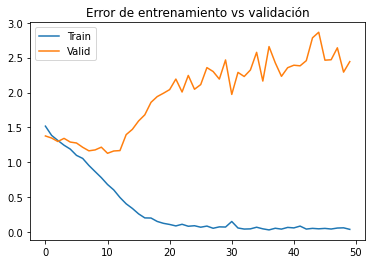

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

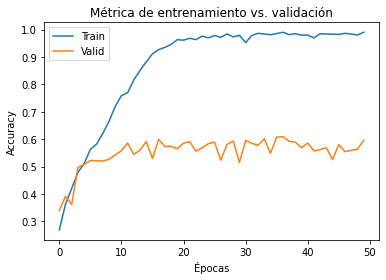

In [ ]:
plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

### Caso 2 - sin data augmentation

#### Creación de los dataloaders con las trasformaciones del modelo aplicadas

In [ ]:
weights_alexnet = AlexNet_Weights.IMAGENET1K_V1
transforms_alexnet = weights_alexnet.transforms()

# Tomamos dataset original sin data augmentation
train_ds_alexnet = copy.deepcopy(train_ds_original)
val_ds_alexnet = copy.deepcopy(val_ds_original)
test_ds_alexnet = copy.deepcopy(test_ds_original)

#Pasamos a tensor
train_ds_alexnet.dataset.transform = transform_to_tensor
val_ds_alexnet.dataset.transform = transform_to_tensor
test_ds_alexnet.dataset.transform = transform_to_tensor

#Aplicamos las transformaciones de los pesos de alexnet
train_ds_alexnet.dataset.transform = transforms_alexnet
val_ds_alexnet.dataset.transform = transforms_alexnet
test_ds_alexnet.dataset.transform = transforms_alexnet

train_loader_alexnet = torch.utils.data.DataLoader(train_ds_alexnet, batch_size=32, shuffle=True)
valid_loader_alexnet = torch.utils.data.DataLoader(val_ds_alexnet, batch_size=32, shuffle=True)
test_loader_alexnet = torch.utils.data.DataLoader(test_ds_alexnet, batch_size=32, shuffle=True)


#### Generamos el modelo sin pesos pre-entrenados

In [ ]:
alexnet_model = modelos.alexnet()#weights=weights_alexnet

alexnet_model.to("cuda")

torchsummary.summary(alexnet_model, input_size=(3, 224, 224))
alexnet_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

<bound method Module.modules of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216,

In [ ]:
## Seteamos que todos los parametros se entrenen
for param in alexnet_model.parameters():
    param.requires_grad = True

In [ ]:
# Reemplazamos la ultima capa por una que a la salida tenga 5 características,
# porque son 5 clases.
last_layer_in_features = alexnet_model.classifier[-1].in_features
alexnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=cantidad_clases)

In [ ]:
alexnet_model.to("cuda")
torchsummary.summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

#### Definición de optimizador y función de pérdida

In [ ]:
# Definimos el optimizador, la función de pérdida y la ruta en donde se almacenará el modelo.
optimizer_ft = torch.optim.Adam(alexnet_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
model_name = '/content/drive/MyDrive/Colab Notebooks/alexnet_sin_pre_train_sin_dat_aug.pth'

#### Entrenamiento y validación

In [ ]:
# Se entrena el modelo
result_model, history,best_epoch,best_acc_val_alexnet_sin_da = train(alexnet_model, criterion, optimizer_ft, train_loader_alexnet, valid_loader_alexnet, 50,model_name)

Epoch: 1/50 - Train loss 1.509238 - Train Accuracy 0.249436 - Valid Loss 1.389457 - Valid Accuracy 0.344141
Epoch: 2/50 - Train loss 1.375110 - Train Accuracy 0.383459 - Valid Loss 1.316717 - Valid Accuracy 0.404229
Epoch: 3/50 - Train loss 1.308295 - Train Accuracy 0.439582 - Valid Loss 1.261979 - Valid Accuracy 0.445910
Epoch: 4/50 - Train loss 1.251661 - Train Accuracy 0.461329 - Valid Loss 1.214159 - Valid Accuracy 0.473774
Epoch: 5/50 - Train loss 1.189626 - Train Accuracy 0.502852 - Valid Loss 1.238401 - Valid Accuracy 0.520897
Epoch: 6/50 - Train loss 1.133716 - Train Accuracy 0.538171 - Valid Loss 1.221367 - Valid Accuracy 0.526980
Epoch: 7/50 - Train loss 1.029789 - Train Accuracy 0.596227 - Valid Loss 1.150944 - Valid Accuracy 0.556288
Epoch: 8/50 - Train loss 0.942309 - Train Accuracy 0.628497 - Valid Loss 1.107983 - Valid Accuracy 0.518577
Epoch: 9/50 - Train loss 0.866212 - Train Accuracy 0.668683 - Valid Loss 1.125614 - Valid Accuracy 0.528755
Epoch: 10/50 - Train loss 0.

In [ ]:
print("La mejor epoch de la ejecucion fue la ",best_epoch)

La mejor epoch de la ejecucion fue la  20


#### Prueba

In [ ]:
test_loss_alexnet_sin_da, test_accuracy_alexnet_sin_da  = test(alexnet_model, criterion, model_name, test_loader_alexnet)

El modelo logro un error de 1.560736 y una accuracy de 0.646306


#### Gráficos de resultados

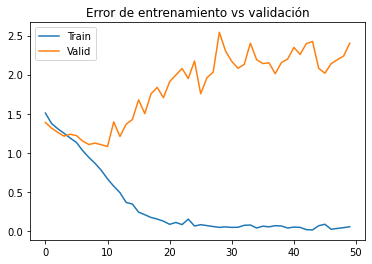

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

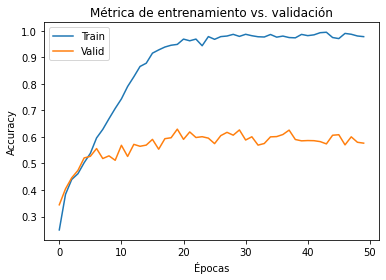

In [ ]:
plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Métrica de entrenamiento vs. validación")
plt.legend(['Train', 'Valid'])
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.show()

## Análisis de resultados y conclusiones

### Resultados

In [ ]:
metrics_show = [ ["s/preTrain s/ DA", best_acc_val_alexnet_sin_da, test_accuracy_alexnet_sin_da,'57.024.325','57.024.325'],
                 ["s/preTrain c/ DA", best_acc_val_alexnet_da, test_accuracy_alexnet_da,'57.024.325','57.024.325'],
                 ["c/preTrain s/ DA", '0.813303', '0.71798','57.024.325','20.485'],
                 ["c/preTrain c/ DA", '0.801950', '0.73703','57.024.325','20.485']]
dataframe_conclusion = pd.DataFrame(metrics_show, columns = ['Modelo','Acc Validation','Acc Test','Total Params','Trainable Params'])
print(dataframe_conclusion)

             Modelo Acc Validation  Acc Test Total Params Trainable Params
0  s/preTrain s/ DA       0.629442  0.646306   57.024.325       57.024.325
1  s/preTrain c/ DA       0.609096  0.608515   57.024.325       57.024.325
2  c/preTrain s/ DA       0.813303   0.71798   57.024.325           20.485
3  c/preTrain c/ DA       0.801950   0.73703   57.024.325           20.485


Conclusiones

Los modelos en los cuales se aplicó transfer learning, además de tener menos parámetros para entrenar, son los que alcanzan la mejor accuracy.

Por otro lado, los modelos en los cuales se aplica data augmentation obtienen menor accuracy que los otros, excepto para el accuracy de pruebas del modelo con trasfer learning, que obtiene el primer lugar entre todas las alternativas experimentadas.